--- 🔬 Simulating Model-Level Optimization: Attention Grouping (GQA) ---

--- Simulation Summary ---
Simulated Sequence Length: 8192 tokens
MHA Cache Size (32 KV heads):      4.000 GB (Baseline)
GQA Cache Size (8 KV heads):      1.000 GB
MQA Cache Size (1 KV head):        0.125 GB

✅ GQA reduces KV cache memory by 75.00% vs. MHA.
✅ MQA reduces KV cache memory by 96.88% vs. MHA.

📊 Graph saved as 'gqa_simulation.png'


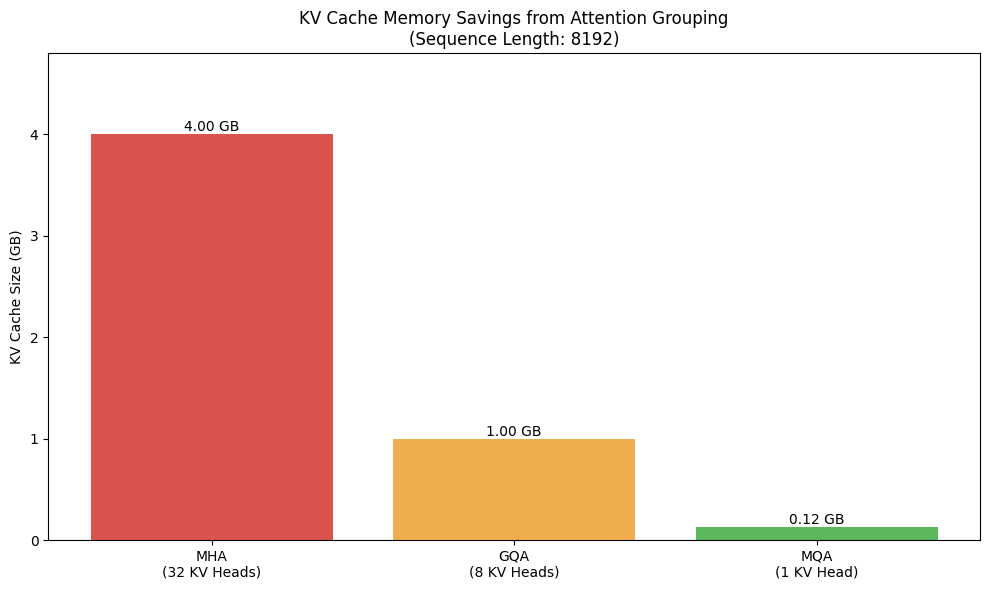

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# We'll use parameters similar to a Llama 2 7B model for a realistic simulation.
MODEL_CONFIG = {
    "num_layers": 32,
    "hidden_size": 4096,
    "num_query_heads": 32,
    "num_gqa_groups": 4,   # 4 groups of 8 Q heads share a K/V head
}

# Simulation parameters
SEQUENCE_LENGTH = 8192
BATCH_SIZE = 1
BYTES_PER_ELEMENT = 2  # For FP16 precision

def calculate_kv_cache_vram(config, num_kv_heads, sequence_length):
    """
    Calculates the theoretical VRAM usage for a KV cache.
    This is an example of Intra-Layer Grouping (Sec. 5.1.1 from the paper).
    """
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    num_query_heads = config["num_query_heads"]
    
    # head_size is the dimension of each head's vector
    head_size = hidden_size // num_query_heads
    
    # Formula: Batch * SeqLen * Layers * 2 (for K,V) * Num_KV_Heads * Size_per_Head * Bytes
    total_bytes = (
        BATCH_SIZE * sequence_length * num_layers * 2 * num_kv_heads * head_size * BYTES_PER_ELEMENT
    )
    
    # Convert bytes to gigabytes
    total_gb = total_bytes / (1024**3)
    return total_gb

def main():
    print("--- 🔬 Simulating Model-Level Optimization: Attention Grouping (GQA) ---")

    # --- 1. Calculate for standard Multi-Head Attention (MHA) ---
    # In MHA, num_kv_heads equals num_query_heads[cite: 659].
    mha_kv_heads = MODEL_CONFIG["num_query_heads"]
    mha_vram = calculate_kv_cache_vram(MODEL_CONFIG, mha_kv_heads, SEQUENCE_LENGTH)

    # --- 2. Calculate for Grouped-Query Attention (GQA) ---
    # In GQA, KV heads are shared among groups.
    gqa_kv_heads = MODEL_CONFIG["num_query_heads"] // MODEL_CONFIG["num_gqa_groups"]
    gqa_vram = calculate_kv_cache_vram(MODEL_CONFIG, gqa_kv_heads, SEQUENCE_LENGTH)

    # --- 3. Calculate for Multi-Query Attention (MQA) ---
    # In MQA, all Query heads share a single KV head[cite: 660].
    mqa_kv_heads = 1
    mqa_vram = calculate_kv_cache_vram(MODEL_CONFIG, mqa_kv_heads, SEQUENCE_LENGTH)
    
    print("\n--- Simulation Summary ---")
    print(f"Simulated Sequence Length: {SEQUENCE_LENGTH} tokens")
    print(f"MHA Cache Size ({mha_kv_heads} KV heads):      {mha_vram:.3f} GB (Baseline)")
    print(f"GQA Cache Size ({gqa_kv_heads} KV heads):      {gqa_vram:.3f} GB")
    print(f"MQA Cache Size ({mqa_kv_heads} KV head):        {mqa_vram:.3f} GB")
    
    print(f"\n✅ GQA reduces KV cache memory by {(1 - gqa_vram / mha_vram) * 100:.2f}% vs. MHA.")
    print(f"✅ MQA reduces KV cache memory by {(1 - mqa_vram / mha_vram) * 100:.2f}% vs. MHA.")

    # --- 4. Plot the results ---
    labels = [f'MHA\n({mha_kv_heads} KV Heads)', f'GQA\n({gqa_kv_heads} KV Heads)', f'MQA\n({mqa_kv_heads} KV Head)']
    vram_sizes = [mha_vram, gqa_vram, mqa_vram]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, vram_sizes, color=['#d9534f', '#f0ad4e', '#5cb85c'])
    plt.ylabel('KV Cache Size (GB)')
    plt.title(f'KV Cache Memory Savings from Attention Grouping\n(Sequence Length: {SEQUENCE_LENGTH})')
    plt.ylim(0, max(vram_sizes) * 1.2)

    # Add text labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f} GB', va='bottom', ha='center')

    plt.tight_layout()
    plt.savefig("gqa_simulation.png")
    print("\n📊 Graph saved as 'gqa_simulation.png'")
    plt.show()

if __name__ == "__main__":
    main()